In [ ]:
#import necessary packages

In [139]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Input
from tensorflow.keras. preprocessing import image
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import model_to_dot
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
#from sklearn.utils import shuffle
#from adabound import AdaBound
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
#import math
import cv2
import os

In [135]:
#Data preprocessing specifications/definitions
img_height = 200
img_width = 200
#img_batch_size = 4
no_channels = 3

IMG_DIR ='coarse21/Images'
CSV_DIR ='coarse21/labels1.csv'


csv_df = pd.read_csv(CSV_DIR)
csv_df = csv_df.sample(frac=1)
#pd.set_option('display.max_rows', None)
csv_df = pd.get_dummies(csv_df, columns=['Coarse','Fine'], drop_first=True, prefix=['Coarse', 'Fine'])




def test_1(batch_size, num_samples):
    
    while 1:
        for offset in range(0, num_samples, batch_size):
            batch_df = csv_df.iloc[offset:offset+batch_size] #splits the rows into batches
            batch_df = batch_df.values

            for row in batch_df:
                #images
                img = image.load_img(IMG_DIR+'//'+ row[0], target_size= (200,200))
                X = image.img_to_array(img)
                X = X/255
                X = np.expand_dims(X,axis= 0)
                imagen = np.vstack([X])

                #1st output
                train_y1= row[1]
                train_y1 = np.asarray(train_y1).astype('float32')
                train_y1 = np.expand_dims(train_y1, axis = 0)
                #2nd output
                train_y2= row[2:5]
                train_y2 = np.asarray(train_y2).astype('float32')
                train_y2 = np.expand_dims(train_y2, axis = 0)

                examples = np.array(imagen)
                labels1 = np.array(train_y1)
                labels2 = np.array(train_y2)
                yield(examples,[labels1, labels2])



#Defining the no. of generated classes for each branch
coarse2_classes = 1 #good state, partially damaged, damaged
fine_classes = 3 #rusty, body, door, none


"batch_generator(x, y, batch_size, is_train):\n    sample_idx = 0\n    while True:\n       X = np.zeros((batch_size, input_height, input_width, n_channels), dtype='float32')\n       y1 = np.zeros((batch_size, mask_height, mask_width), dtype='float32')\n       y2 = np.zeros((batch_size, 1), dtype='float32')\n\n       # fill up the batch\n       for row in range(batch_sz):\n           image = x[sample_idx]\n           mask = y[0][sample_idx]\n           binary_value = y[1][sample_idx]\n           # transform/preprocess image\n           image = cv2.resize(image, (input_width, input_height))\n           if is_train:\n               image, mask = my_data_augmentation_function(image, mask)\n           X_batch[row, ;, :, :] = image\n           y1_batch[row, :, :] = mask\n           y2_batch[row, 0] = binary_value\n           sample_idx += 1\n\n       # Normalize inputs\n       X_batch = X_batch/255.\n       yield(X_batch, {'output1': y1_batch, 'output2': y2_batch} ))"

In [5]:
#blocks 1,2 and 3 architecture for the coarse2 branch

In [13]:
#Block 1
input_shape =(img_height,img_width,no_channels)
img_dimension = Input(shape= input_shape, name='input_dim')
#1st convolution and its input tensor
layer = tf.keras.layers.Conv2D(64,(3,3), padding= 'same', activation= 'relu', name='block1_conv1')(img_dimension)
layer = tf.keras.layers.BatchNormalization()(layer)
#2nd convolution
layer = tf.keras.layers.Conv2D(64,(3,3), padding= 'same', activation= 'relu', name='block1_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#1st pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block1_pool')(layer)

#Block 2
#3rd convolution
layer = tf.keras.layers.Conv2D(128,(3,3), padding= 'same', activation= 'relu', name='block2_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#4th convolution
layer = tf.keras.layers.Conv2D(128,(3,3), padding= 'same', activation= 'relu', name='block2_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#2nd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block2_pool')(layer)

#Block 3
#5th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#6th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#7th convolution
layer = tf.keras.layers.Conv2D(256,(3,3), padding= 'same', activation= 'relu', name='block3_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#3rd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block3_pool')(layer)

#Coarse 2 branch fc layer
c2_branch = tf.keras.layers.Flatten()(layer)
#c2 branch's 1st dense layer
c2_branch = tf.keras.layers.Dense(1024,activation= 'relu', name='c2_dense1')(c2_branch)
c2_branch = tf.keras.layers.BatchNormalization()(c2_branch)
c2_branch = tf.keras.layers.Dropout(0.5)(c2_branch)
#c2 branch's 2nd dense layer
c2_branch = tf.keras.layers.Dense(1024,activation= 'relu', name='c2_dense2')(c2_branch)
c2_branch = tf.keras.layers.BatchNormalization()(c2_branch)
c2_branch = tf.keras.layers.Dropout(0.5)(c2_branch)
#c2 branch's output layer
c2_branch_out = tf.keras.layers.Dense(coarse2_classes, activation= 'sigmoid', name='c2_last_dense_layer')(c2_branch)

#Block 4
#8th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block4_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#9th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block4_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#10th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block4_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#4rd pooling
layer = tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2), name='block4_pool')(layer)

#Block 5
#11th convolution

layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block5_conv1')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#12th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block5_conv2')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)
#13th convolution
layer = tf.keras.layers.Conv2D(512,(3,3), padding= 'same', activation= 'relu', name='block5_conv3')(layer)
layer = tf.keras.layers.BatchNormalization()(layer)

#Fine branch fc layer
fine_branch = tf.keras.layers.Flatten()(layer)
#fine branch's 1st dense layer
fine_branch = tf.keras.layers.Dense(4096,activation= 'relu', name='fine_dense1')(fine_branch)
fine_branch = tf.keras.layers.BatchNormalization()(fine_branch)
fine_branch = tf.keras.layers.Dropout(0.5)(fine_branch)
#fine branch's 2nd dense layer
fine_branch = tf.keras.layers.Dense(4096,activation= 'relu', name='fine_dense2')(fine_branch)
fine_branch = tf.keras.layers.BatchNormalization()(fine_branch)
fine_branch = tf.keras.layers.Dropout(0.5)(fine_branch)
#fine branch's output layer
fine_branch_out = tf.keras.layers.Dense(fine_classes, activation= 'softmax', name='fine_last_dense_layer')(fine_branch)

#Puting the learning model together
model = tf.keras.Model(inputs= img_dimension, outputs= [c2_branch_out, fine_branch_out], name= 'edp_eb_hierarchy')

In [140]:
model.compile(loss= {'c2_last_dense_layer': 'binary_crossentropy', 'fine_last_dense_layer': 'categorical_crossentropy'},
             optimizer = RMSprop(lr=1e-04), #Adam(lr=1e-03),
             metrics =['accuracy'])

In [134]:
print(model.summary())
tf.keras.utils.plot_model(model, "my_first_model.png")
tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

model_fit = model.fit(train_c2_set,
                     verbose=1,
                     epochs= 80)

Model: "edp_eb_hierarchy"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_dim (InputLayer)          [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 32, 32, 64)   1792        input_dim[0][0]                  
__________________________________________________________________________________________________
batch_normalization_85 (BatchNo (None, 32, 32, 64)   256         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 32, 32, 64)   36928       batch_normalization_85[0][0]     
___________________________________________________________________________________

22/22 [==============================] - 14s 627ms/step - loss: 4.7611 - c2_last_dense_layer_loss: 0.8689 - fine_last_dense_layer_loss: 3.8922 - c2_last_dense_layer_accuracy: 0.5325 - fine_last_dense_layer_accuracy: 0.2987
Epoch 2/80
22/22 [==============================] - 14s 625ms/step - loss: 4.1617 - c2_last_dense_layer_loss: 0.8558 - fine_last_dense_layer_loss: 3.3060 - c2_last_dense_layer_accuracy: 0.5714 - fine_last_dense_layer_accuracy: 0.3896
Epoch 3/80
22/22 [==============================] - 14s 622ms/step - loss: 4.7381 - c2_last_dense_layer_loss: 0.7849 - fine_last_dense_layer_loss: 3.9532 - c2_last_dense_layer_accuracy: 0.5649 - fine_last_dense_layer_accuracy: 0.3571
Epoch 4/80
22/22 [==============================] - 14s 655ms/step - loss: 4.2942 - c2_last_dense_layer_loss: 0.6613 - fine_last_dense_layer_loss: 3.6329 - c2_last_dense_layer_accuracy: 0.6883 - fine_last_dense_layer_accuracy: 0.3442
Epoch 5/80
22/22 [==============================] - 15s 683ms/step - loss: 

22/22 [==============================] - 18s 818ms/step - loss: 3.5263 - c2_last_dense_layer_loss: 0.8358 - fine_last_dense_layer_loss: 2.6905 - c2_last_dense_layer_accuracy: 0.6364 - fine_last_dense_layer_accuracy: 0.3442
Epoch 70/80
22/22 [==============================] - 18s 839ms/step - loss: 3.6649 - c2_last_dense_layer_loss: 0.6534 - fine_last_dense_layer_loss: 3.0115 - c2_last_dense_layer_accuracy: 0.6364 - fine_last_dense_layer_accuracy: 0.3571
Epoch 71/80
22/22 [==============================] - 18s 806ms/step - loss: 3.2553 - c2_last_dense_layer_loss: 0.7189 - fine_last_dense_layer_loss: 2.5364 - c2_last_dense_layer_accuracy: 0.6299 - fine_last_dense_layer_accuracy: 0.3117
Epoch 72/80
22/22 [==============================] - 18s 828ms/step - loss: 3.3915 - c2_last_dense_layer_loss: 0.8287 - fine_last_dense_layer_loss: 2.5627 - c2_last_dense_layer_accuracy: 0.5649 - fine_last_dense_layer_accuracy: 0.3636
Epoch 73/80
22/22 [==============================] - 19s 847ms/step - lo

In [158]:
model_fit = model.fit(train_c2_set,
                     #steps_per_epoch= 5,
                     verbose=1,
                     epochs= 80)

Epoch 1/80
22/22 [==============================] - 211s 10s/step - loss: 8.6254 - c2_last_dense_layer_loss: 1.7706 - fine_last_dense_layer_loss: 6.8548 - c2_last_dense_layer_accuracy: 0.5325 - fine_last_dense_layer_accuracy: 0.3182
Epoch 2/80
22/22 [==============================] - 230s 10s/step - loss: 5.2152 - c2_last_dense_layer_loss: 1.4737 - fine_last_dense_layer_loss: 3.7415 - c2_last_dense_layer_accuracy: 0.5325 - fine_last_dense_layer_accuracy: 0.3182
Epoch 3/80
22/22 [==============================] - 225s 10s/step - loss: 3.8132 - c2_last_dense_layer_loss: 1.2025 - fine_last_dense_layer_loss: 2.6107 - c2_last_dense_layer_accuracy: 0.6039 - fine_last_dense_layer_accuracy: 0.4091
Epoch 4/80
22/22 [==============================] - 226s 10s/step - loss: 3.5836 - c2_last_dense_layer_loss: 1.1646 - fine_last_dense_layer_loss: 2.4190 - c2_last_dense_layer_accuracy: 0.6299 - fine_last_dense_layer_accuracy: 0.3961
Epoch 5/80
22/22 [==============================] - 231s 10s/step - 

22/22 [==============================] - 225s 10s/step - loss: 2.4649 - c2_last_dense_layer_loss: 0.2928 - fine_last_dense_layer_loss: 2.1721 - c2_last_dense_layer_accuracy: 0.9026 - fine_last_dense_layer_accuracy: 0.5065
Epoch 72/80
22/22 [==============================] - 231s 10s/step - loss: 2.3169 - c2_last_dense_layer_loss: 0.4112 - fine_last_dense_layer_loss: 1.9057 - c2_last_dense_layer_accuracy: 0.8636 - fine_last_dense_layer_accuracy: 0.4740
Epoch 73/80
22/22 [==============================] - 230s 10s/step - loss: 2.5104 - c2_last_dense_layer_loss: 0.5251 - fine_last_dense_layer_loss: 1.9853 - c2_last_dense_layer_accuracy: 0.7922 - fine_last_dense_layer_accuracy: 0.5195
Epoch 74/80
22/22 [==============================] - 194s 9s/step - loss: 2.3226 - c2_last_dense_layer_loss: 0.5147 - fine_last_dense_layer_loss: 1.8080 - c2_last_dense_layer_accuracy: 0.8377 - fine_last_dense_layer_accuracy: 0.5260
Epoch 75/80
22/22 [==============================] - 196s 9s/step - loss: 2.4

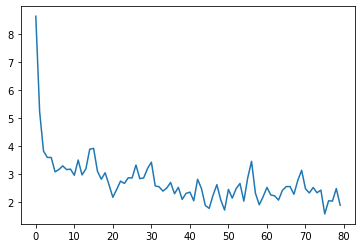

In [164]:
plt.plot(model_fit.history['loss'])
plt.show()

In [15]:
latest = tf.train.latest_checkpoint("ipynb_checkpoints/Untitled-checkpoint.ipynb")
model.load_weights(latest)http://localhost:8888/notebooks/Documents/damage_detect/Untitled.ipynb#


AttributeError: 'NoneType' object has no attribute 'endswith'

In [89]:
#SAVE LEARNING MODEL'S WEIGHTS

checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

batch_size = 22

cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq=5*batch_size)

model.save_weights(checkpoint_path.format(epoch=0))

latest = tf.train.latest_checkpoint(checkpoint_dir)

model.load_weights(latest) #load last weights

model_fit = model.fit(train_c2_set,
                     verbose=1,
                     callbacks=[cp_callback],
                     epochs= 5,
                     )

Epoch 1/5
22/22 [==============================] - 188s 9s/step - loss: 0.5118 - c2_last_dense_layer_loss: 0.1599 - fine_last_dense_layer_loss: 0.3519 - c2_last_dense_layer_accuracy: 0.9351 - fine_last_dense_layer_accuracy: 0.9156
Epoch 2/5
22/22 [==============================] - 194s 9s/step - loss: 0.3353 - c2_last_dense_layer_loss: 0.1215 - fine_last_dense_layer_loss: 0.2138 - c2_last_dense_layer_accuracy: 0.9610 - fine_last_dense_layer_accuracy: 0.9156
Epoch 3/5
22/22 [==============================] - 195s 9s/step - loss: 0.4643 - c2_last_dense_layer_loss: 0.1514 - fine_last_dense_layer_loss: 0.3129 - c2_last_dense_layer_accuracy: 0.9416 - fine_last_dense_layer_accuracy: 0.8766
Epoch 4/5
22/22 [==============================] - 194s 9s/step - loss: 0.3658 - c2_last_dense_layer_loss: 0.1289 - fine_last_dense_layer_loss: 0.2370 - c2_last_dense_layer_accuracy: 0.9481 - fine_last_dense_layer_accuracy: 0.9416
Epoch 5/5
21/22 [===========================>..] - ETA: 8s - loss: 0.3248 - 

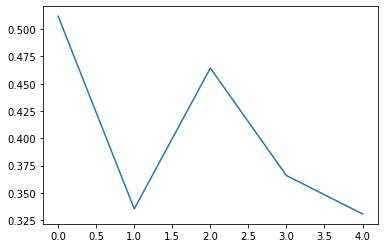

In [97]:
plt.plot(model_fit.history['loss'])
plt.show()

In [141]:
model_fit = model.fit(test_1(4, 156),
                     verbose=1,
                      steps_per_epoch=156,
                     #callbacks=[cp_callback],
                     epochs= 20
                     )

Epoch 1/20
156/156 [==============================] - 772s 5s/step - loss: 2.2241 - c2_last_dense_layer_loss: 0.6911 - fine_last_dense_layer_loss: 1.5330 - c2_last_dense_layer_accuracy: 0.5064 - fine_last_dense_layer_accuracy: 0.3974
Epoch 2/20
156/156 [==============================] - 828s 5s/step - loss: 2.0269 - c2_last_dense_layer_loss: 0.6923 - fine_last_dense_layer_loss: 1.3346 - c2_last_dense_layer_accuracy: 0.5128 - fine_last_dense_layer_accuracy: 0.3910
Epoch 3/20
156/156 [==============================] - 912s 6s/step - loss: 2.0838 - c2_last_dense_layer_loss: 0.6917 - fine_last_dense_layer_loss: 1.3921 - c2_last_dense_layer_accuracy: 0.5128 - fine_last_dense_layer_accuracy: 0.3718
Epoch 4/20
156/156 [==============================] - 904s 6s/step - loss: 2.1151 - c2_last_dense_layer_loss: 0.6930 - fine_last_dense_layer_loss: 1.4220 - c2_last_dense_layer_accuracy: 0.5064 - fine_last_dense_layer_accuracy: 0.4038
Epoch 5/20
156/156 [==============================] - 874s 6s/st

In [143]:
model.save_weights("ckpt1")

In [96]:
tf.keras.utils.plot_model(model, "my_first_model.png")
tf.keras.utils.plot_model(model, "my_first_model_with_shape_info.png", show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')
